In [1]:
from obspy.core import read
sta1 = 'A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC'
sta2= 'BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC'

In [2]:
from dispel4py.base import SimpleFunctionPE, IterativePE, create_iterative_chain
def stream_producer(data):
    filename = data
    st = read(filename)
    return st

def readstats(st):
    station_date = st[0].stats['starttime'].date
    station_day = station_date.strftime('%d-%m-%Y')
    station = st[0].stats['station']
    return [station_day, station, st]


In [7]:
def decimate(st, sps):
    st.decimate(int(st[0].stats.sampling_rate/sps))
    return st

def detrend(st):
    st.detrend('simple')
    return st

def demean(st):
    st.detrend('demean')
    return st

def filter(st, freqmin=0.01, freqmax=1., corners=4, zerophase=False):
    st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners, zerophase=zerophase)
    return st


from numpy import arange, sqrt, abs, multiply, conjugate, real
from obspy.signal.util import next_pow_2
from scipy.fftpack import fft, ifft

def spectralwhitening(st):
    """
    Apply spectral whitening to data.
    Data is divided by its smoothed (Default: None) amplitude spectrum.
    """
    
    for trace in arange(len(st)):
        data = st[trace].data
        
        n = len(data)
        nfft = next_pow_2(n)
        
        spec = fft(data, nfft)
        spec_ampl = sqrt(abs(multiply(spec, conjugate(spec))))
        
        spec /= spec_ampl  #Do we need to do some smoothing here?
        ret = real(ifft(spec, nfft)[:n])
        
        st[trace].data = ret
        
    return st


In [8]:
from dispel4py.core import GenericPE
class MatchPE(GenericPE):
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input', grouping=[0])
        self._add_output('output')
        self.data = {}
    def process(self, inputs):
        tup = inputs['input']
        date = tup[0]
        station = tup[1]
        try:
            matching = self.data[date]
            result = [date, tup[2], matching[2]]
            self.write('output', result)
        except:
            self.data[date] = tup

In [9]:
from dispel4py.core import GenericPE
class MatchPE(GenericPE):
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input1', grouping=[0])
        self._add_input('input2', grouping=[0])
        self._add_output('output')
        self.data = {}
    def process(self, inputs):
        try:
            tup = inputs['input1']
        except KeyError:
            tup = inputs['input2']
        date = tup[0]
        station = tup[1]
        try:
            matching = self.data[date]
            result = [date, tup[2], matching[2]]
            self.write('output', result)
        except:
            self.data[date] = tup

In [10]:
from obspy.signal.cross_correlation import xcorr
import numpy
def xcorrelation(data, maxlag):
    st1 = data[1]
    st2 = data[2]
    tr1 = st1[0].data
    tr2 = st2[0].data
    tr1 = tr1/numpy.linalg.norm(tr1)
    tr2 = tr2/numpy.linalg.norm(tr2)
    return xcorr(tr1, tr2, maxlag, full_xcorr=True)[2]

In [11]:
from dispel4py.workflow_graph import WorkflowGraph
streamProducer1 = SimpleFunctionPE(stream_producer)

streamProducer2 = SimpleFunctionPE(stream_producer)

stats1 = SimpleFunctionPE(readstats) 
stats2 = SimpleFunctionPE(readstats) 
match_traces=MatchPE()
xcorrelation_traces= SimpleFunctionPE(xcorrelation, {'maxlag':1000}) 

pipeline = [
    (decimate, {'sps':4}), 
    detrend, 
    demean, 
    (filter, {'freqmin':0.01, 'freqmax':1., 'corners':4, 'zerophase':False}),
    spectralwhitening,
    readstats]
preprocess_trace_1 = create_iterative_chain(pipeline)
preprocess_trace_2 = create_iterative_chain(pipeline)

graph = WorkflowGraph()
graph.connect(streamProducer1, 'output', preprocess_trace_1, 'input')
graph.connect(streamProducer2, 'output', preprocess_trace_2, 'input')
graph.connect(preprocess_trace_1, 'output', match_traces, 'input1')
graph.connect(preprocess_trace_2, 'output', match_traces, 'input2')
graph.connect(match_traces, 'output', xcorrelation_traces, 'input')

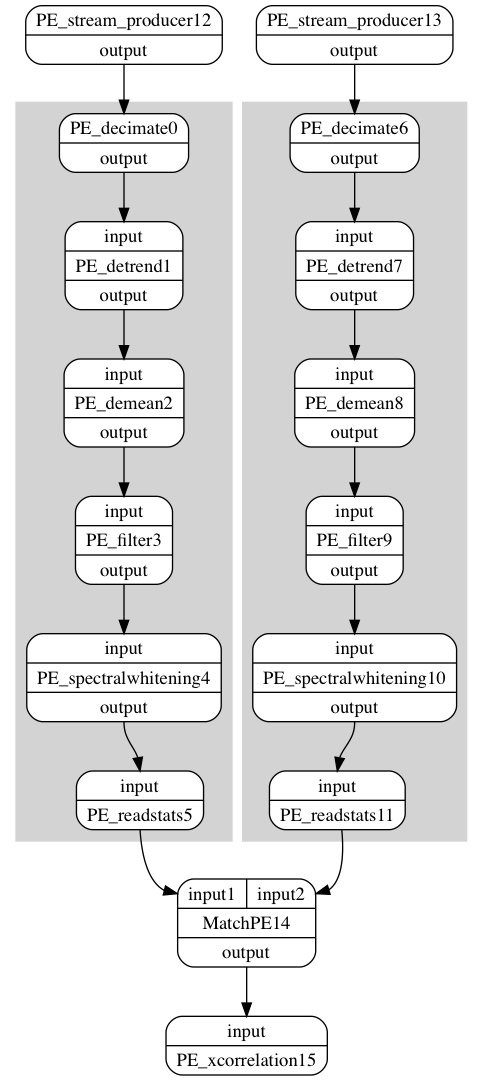

In [12]:
from dispel4py.visualisation import display
display(graph)

In [13]:
from dispel4py.new.simple_process import process as simple_process
input_data = {streamProducer1: [{ 'input' : sta1 }],streamProducer2:[{'input' : sta2 }]}
graph.flatten()
simple_process(graph, input_data)

Inputs: {'PE_stream_producer12': [{'input': 'A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC'}], 'PE_stream_producer13': [{'input': 'BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC'}]}


/anaconda3/envs/mypython3/lib/python3.7/site-packages/obspy/signal/cross_correlation.py:220: ObsPyDeprecationWarning: Call to deprecated function xcorr(). Please use the correlate and xcorr_max functions.
  warnings.warn(msg, ObsPyDeprecationWarning)


SimplePE: Processed 1 iteration.
Outputs: {'PE_xcorrelation15': {'output': [array([-0.00276582, -0.00010264,  0.00063808, ...,  0.00042522,
       -0.00168727, -0.00041316])]}}


In [ ]:
!mpiexec -n 6 dispel4py mpi dispel4py.examples.graph_testing.pipeline_test